### Import stuff

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys  
sys.path.insert(0, '/home/jupyter/repositories/InternalVariability/AdaptationAnalysis')

In [4]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd
import intake 
import pprint
import xesmf
from CMIP6_Utils import *

In [5]:
from app.main.src.climate_projection import ClimateProjection
from app.main.src.year_of_departure import *
from app.main.src.datasets import *
from app.main.src.post_processing import BiasCorrection, NoPostProcessing

### Get CMIP6 data 

In [6]:
# set lat/lon 
lat=65
lon=-19
# for global 
# lat = slice(None, None)
# lon = slice(None, None)

In [7]:
# get datasets via ClimateProjection workflow
# do monthly data first (using daily takes a while to load)
cp = ClimateProjection(
    lat=lat,
    lon=lon,
    variables=['t2m', 't2m_max', 't2m_min', 'tp'],    
    scenario='ssp585',
#     n_models=5,
    projection_name='internal_variability_iceland',
    gcs_bucket='climateai_data_repository',      
    gcs_path='tmp/internal_variability',
    overwrite=False,
    daily=False
)

In [8]:
# load the data for point location
#cross validate should always be false
cp.load(cross_validate=False,check_exist=True)

In [60]:
# # for global 
# cp.load(cross_validate=False,check_exist=True,
#         pp_method={'monthly' : {'t2m':BiasCorrection,
#                                 't2m_max':BiasCorrection,
#                                 't2m_min':BiasCorrection,
#                                 'tp':NoPostProcessing}},
#        interp_dx=2.5)

## Reproduce HS09
Here we will reproduce the model uncertainty and internal varaibility estimates using methodology from HS09 (i.e. fitting the data with a 4th order polynomial) 

### Prepare the data 

### test workflow

In [61]:
# decadal average 
data_averaged = prepare_data(dataset1=cp.pp_hist_monthly,dataset2=cp.pp_future_monthly)

In [62]:
# get data without doing decadal average 
dataset1 = cp.pp_hist_monthly
dataset2 = cp.pp_future_monthly
# dataset1 = cp.raw_hist_monthly, dataset2 = cp.raw_future_monthly
data = xr.concat([dataset1, dataset2], dim='time').resample(time='AS').mean().t2m.dropna('model')

In [63]:
# # for global data 
# data = data.mean(dim=('lon','lat'))
# data_averaged = data_averaged.mean(dim=('lon','lat'))

In [64]:
data_ref = get_reference_data(dataset=cp.pp_hist_monthly,year1='1985',year2='2005')

In [65]:
# # global reference
# data_ref = data_ref.mean(dim=('lon','lat'))

In [66]:
data_ref

<xarray.DataArray 't2m' ()>
array(-0.40855235)
Coordinates:
    lat      int64 65
    lon      int64 -19

In [67]:
    # need to rename all variables in order to merge later
data_ref = data_ref.rename('t2m_ref')
    
    # implicit bias correction 
data_averaged = data_averaged-data_ref
data_averaged = data_averaged.rename('t2m_averaged')
data = data-data_ref
data = data.rename('t2m')
    
    #do the 4th order polyfit
fit = polyfit(data)
fit = fit.rename('t2m_fit')
fit_averaged = polyfit(data_averaged)
fit_averaged = fit.rename('t2m_fit_averaged')
    
    # calculate residual
residual = data_averaged - fit_averaged
    
    #calculate internal variability 
internal = residual.var('time').mean('model')
internal = internal.rename('internal_fit')
    
    #calculate model uncertainty 
model_uncertainty = fit.var('model')                    
model_uncertainty = model_uncertainty.rename('model_fit')
    
    #calculate total uncertainty directly and via variances 
total_direct = data.var('model')
total_direct = total_direct.rename('total_direct')
total = internal + model_uncertainty
total = total.rename('total')
    
    #calculate internal and model fractional contribiution to total uncertainty (%) 
internal_frac = (internal/total)*100
internal_frac = internal_frac.rename('internal_frac')
model_frac = (model_uncertainty/total)*100
model_frac = model_frac.rename('model_frac')
    
    #create xarray dataset and merge results together 
dataset = xr.merge([data,data_ref,
                    data_averaged,fit_averaged,
                    fit,internal,model_uncertainty,
                    total_direct,total,internal_frac,model_frac])

In [70]:
dataset.to_netcdf('/home/jupyter/data/CMIP6_IntVariability_pp_iceland_testmodel.nc')

### Compare model uncertainties 

datasets with _test are the ones where model uncertainty is calculated without decadal average. Should I be taking a decadal average after model uncertainty is calculated? 

In [6]:
# load datasets 
data_global = xr.open_dataset('/home/jupyter/data/CMIP6_IntVariability_pp_data_global.nc')
data_global_test = xr.open_dataset('/home/jupyter/data/CMIP6_IntVariability_pp_data_global_testmodel.nc')
USeast_test = xr.open_dataset('/home/jupyter/data/CMIP6_IntVariability_pp_USeast_testmodel.nc')
USeast = xr.open_dataset('/home/jupyter/data/CMIP6_IntVariability_pp_USeast.nc')
iceland_test = xr.open_dataset('/home/jupyter/data/CMIP6_IntVariability_pp_iceland_testmodel.nc')
iceland = xr.open_dataset('/home/jupyter/data/CMIP6_IntVariability_pp_iceland.nc')
tropics_test = xr.open_dataset('/home/jupyter/data/CMIP6_IntVariability_pp_tropics_testmodel.nc')
tropics = xr.open_dataset('/home/jupyter/data/CMIP6_IntVariability_pp_tropics.nc')

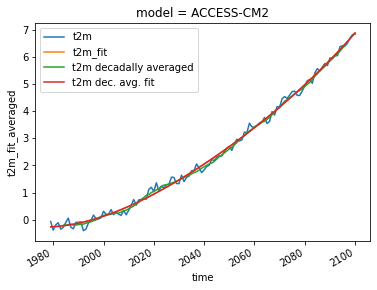

In [21]:
#plot a model and model fit 
data_global_test.t2m.isel(model=0).plot(label='t2m')
data_global_test.t2m_fit.isel(model=0).plot(label='t2m_fit')
data_global_test.t2m_averaged.isel(model=0).plot(label='t2m decadally averaged')
data_global_test.t2m_fit_averaged.isel(model=0).plot(label='t2m dec. avg. fit')
plt.legend()

(0.0, 0.2)

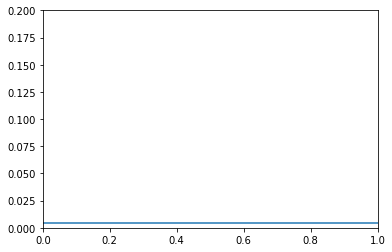

In [22]:
# plot internal variability 
plt.axhline(data_global_test.internal_fit)
plt.ylim(0,0.2)

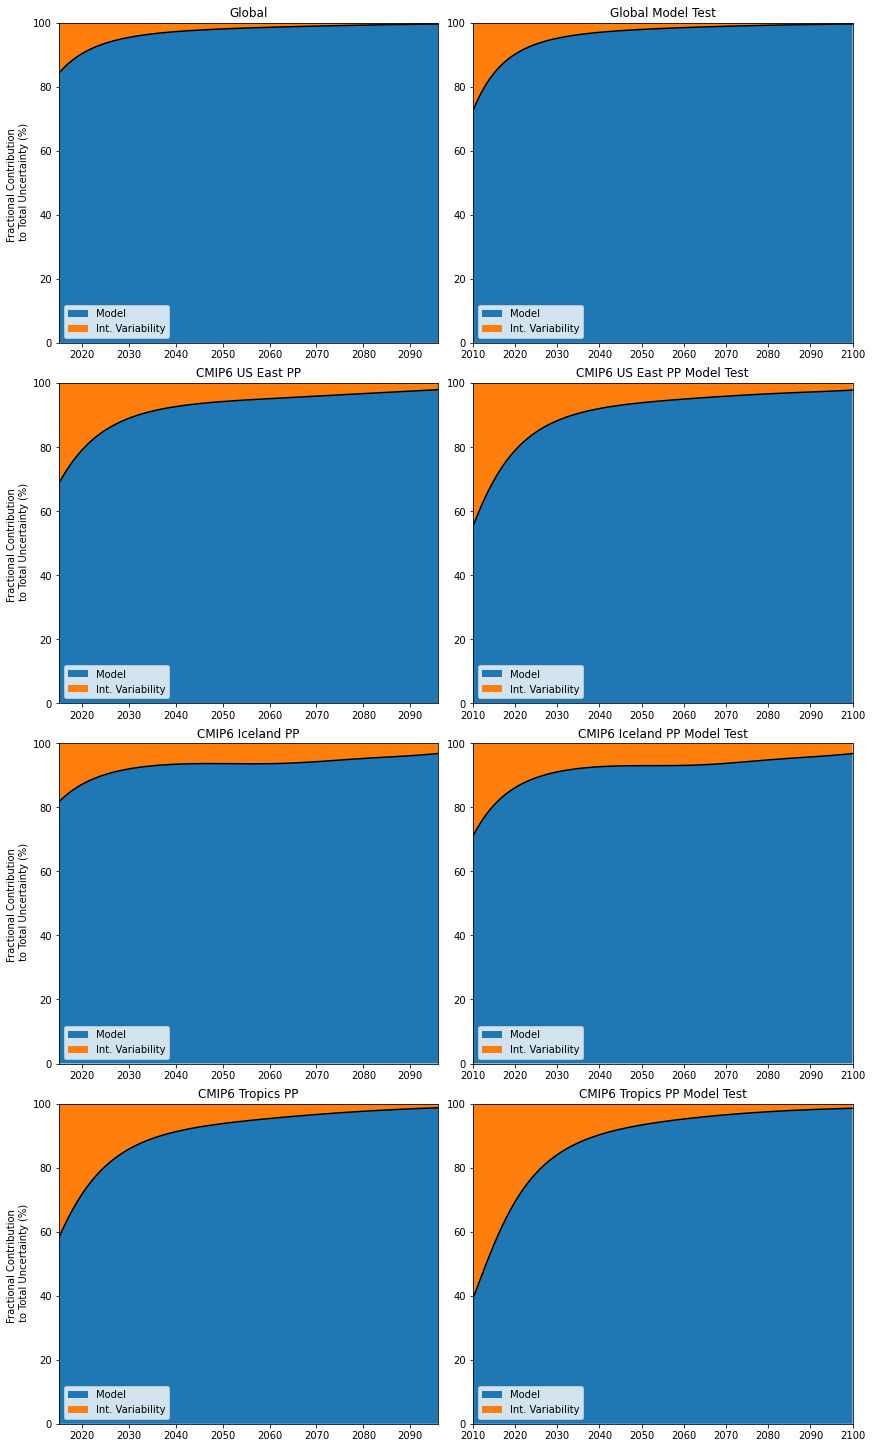

In [11]:
fig,ax = plt.subplots(nrows=4,ncols=2,constrained_layout=True,figsize=(12,20))

regions_pp = [data_global,USeast,iceland,tropics]
axes = np.arange(0,4,1)
titles = ['Global','CMIP6 US East PP','CMIP6 Iceland PP','CMIP6 Tropics PP']
for r,i,t in zip(regions_pp,axes,titles):
    x =r.time
    y =r.model_frac
    ax[i,0].fill_between(x,y,label='Model')
    ax[i,0].plot(r.time,r.model_frac,color='k')
    ax[i,0].fill_between(x,y,100,label='Int. Variability')
    ax[i,0].set_xlim(x[31],x[-1])
    ax[i,0].set_ylim(0,100)
    ax[i,0].legend(loc=3)
    ax[i,0].set_title(t)
    ax[i,0].set_ylabel('Fractional Contribution \n to Total Uncertainty (%)')

regions_test = [data_global_test,USeast_test,iceland_test,tropics_test]
axes = np.arange(0,4,1)
titles = ['Global Model Test','CMIP6 US East PP Model Test','CMIP6 Iceland PP Model Test','CMIP6 Tropics PP Model Test']
for r,i,t in zip(regions_test,axes,titles):
    x = r.time
    y = r.model_frac
    ax[i,1].fill_between(x,y,label='Model')
    ax[i,1].plot(r.time,r.model_frac,color='k')
    ax[i,1].fill_between(x,y,100,label='Int. Variability')
    ax[i,1].set_xlim(x[31],x[-1])
    ax[i,1].set_ylim(0,100)
    ax[i,1].legend(loc=3)
    ax[i,1].set_title(t)

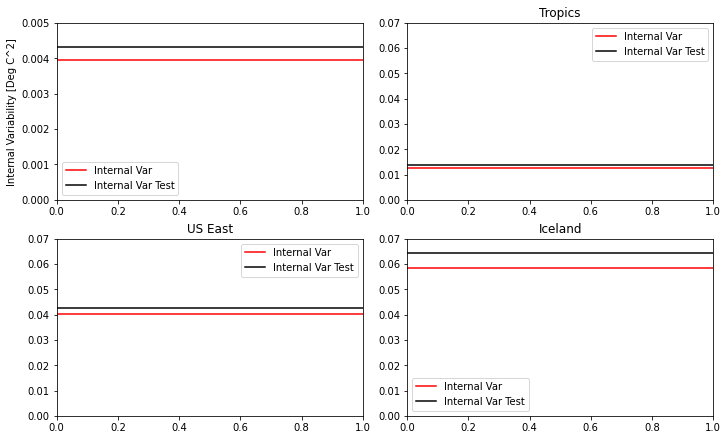

In [21]:
fig,ax = plt.subplots(nrows=2,ncols=2,constrained_layout=True, figsize=(10,6))
ax[0,0].axhline(data_global.internal_fit,color='r',label='Internal Var')
ax[0,0].axhline(data_global_test.internal_fit,color='k',label='Internal Var Test')
ax[0,0].set_ylabel('Global')
ax[0,0].set_ylim(0,0.005)
ax[0,0].legend()

ax[0,1].axhline(tropics.internal_fit,color='r',label='Internal Var')
ax[0,1].axhline(tropics_test.internal_fit,color='k',label='Internal Var Test')
ax[0,1].set_title('Tropics')
ax[0,1].set_ylim(0,0.07)
ax[0,1].legend()

ax[1,0].axhline(USeast.internal_fit,color='r',label='Internal Var')
ax[1,0].axhline(USeast_test.internal_fit,color='k',label='Internal Var Test')
ax[1,0].set_title('US East')
ax[0,0].set_ylabel('Internal Variability [Deg C^2]')
ax[1,0].set_ylim(0,0.07)
ax[1,0].legend()

ax[1,1].axhline(iceland.internal_fit,color='r',label='Internal Var')
ax[1,1].axhline(iceland_test.internal_fit,color='k',label='Internal Var Test')
ax[1,1].set_title('Iceland')
ax[1,1].set_ylim(0,0.07)
ax[1,1].legend()

Internal variability increases in each test case where I calculate model uncertainty using non-decadal rolling averaged data. Does this make sense? I initally thought that internal var would remain the same for both because I am not changing how its calculated. I expected only model uncertainty to change. 

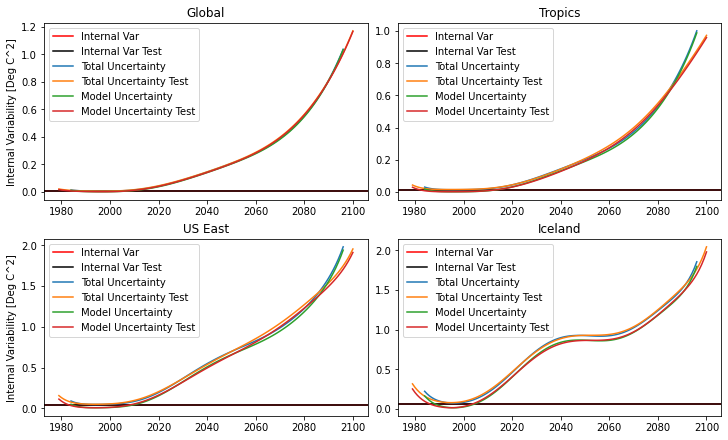

In [25]:
fig,ax = plt.subplots(nrows=2,ncols=2,constrained_layout=True, figsize=(10,6))
ax[0,0].axhline(data_global.internal_fit,color='r',label='Internal Var')
ax[0,0].axhline(data_global_test.internal_fit,color='k',label='Internal Var Test')
ax[0,0].plot(data_global.time,data_global.total,label='Total Uncertainty')
ax[0,0].plot(data_global_test.time,data_global_test.total,label='Total Uncertainty Test')
ax[0,0].plot(data_global.time,data_global.model_fit,label='Model Uncertainty')
ax[0,0].plot(data_global_test.time,data_global_test.model_fit,label='Model Uncertainty Test')
ax[0,0].set_title('Global')
ax[0,0].set_ylabel('Internal Variability [Deg C^2]')
# ax[0,0].set_ylim(0,0.005)
ax[0,0].legend()

ax[0,1].axhline(tropics.internal_fit,color='r',label='Internal Var')
ax[0,1].axhline(tropics_test.internal_fit,color='k',label='Internal Var Test')
ax[0,1].plot(tropics.time,tropics.total,label='Total Uncertainty')
ax[0,1].plot(tropics_test.time,tropics_test.total,label='Total Uncertainty Test')
ax[0,1].plot(tropics.time,tropics.model_fit,label='Model Uncertainty')
ax[0,1].plot(tropics_test.time,tropics_test.model_fit,label='Model Uncertainty Test')
ax[0,1].set_title('Tropics')
# ax[0,1].set_ylim(0,0.07)
ax[0,1].legend()

ax[1,0].axhline(USeast.internal_fit,color='r',label='Internal Var')
ax[1,0].axhline(USeast_test.internal_fit,color='k',label='Internal Var Test')
ax[1,0].plot(USeast.time,USeast.total,label='Total Uncertainty')
ax[1,0].plot(USeast_test.time,USeast_test.total,label='Total Uncertainty Test')
ax[1,0].plot(USeast.time,USeast.model_fit,label='Model Uncertainty')
ax[1,0].plot(USeast_test.time,USeast_test.model_fit,label='Model Uncertainty Test')
ax[1,0].set_title('US East')
ax[1,0].set_ylabel('Internal Variability [Deg C^2]')
# ax[1,0].set_ylim(0,0.07)
ax[1,0].legend()

ax[1,1].axhline(iceland.internal_fit,color='r',label='Internal Var')
ax[1,1].axhline(iceland_test.internal_fit,color='k',label='Internal Var Test')
ax[1,1].plot(iceland.time,iceland.total,label='Total Uncertainty')
ax[1,1].plot(iceland_test.time,iceland_test.total,label='Total Uncertainty Test')
ax[1,1].plot(iceland.time,iceland.model_fit,label='Model Uncertainty')
ax[1,1].plot(iceland_test.time,iceland_test.model_fit,label='Model Uncertainty Test')
ax[1,1].set_title('Iceland')
# ax[1,1].set_ylim(0,0.07)
ax[1,1].legend()

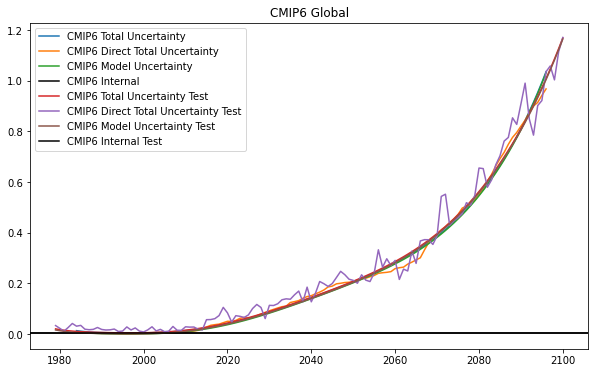

In [27]:
# total uncertainty 
fig = plt.figure(figsize=(10,6))
plt.plot(data_global.time,data_global.total,label='CMIP6 Total Uncertainty')
plt.plot(data_global.time,data_global.total_direct,label='CMIP6 Direct Total Uncertainty')
plt.plot(data_global.time,data_global.model_fit,label='CMIP6 Model Uncertainty')
plt.axhline(data_global.internal_fit,label='CMIP6 Internal',color='k')
# plt.axhline(CESM_global.internal_fit,label='CESM Internal',color='r')

plt.title('CMIP6 Global')

plt.plot(data_global_test.time,data_global_test.total,label='CMIP6 Total Uncertainty Test')
plt.plot(data_global_test.time,data_global_test.total_direct,label='CMIP6 Direct Total Uncertainty Test')
plt.plot(data_global_test.time,data_global_test.model_fit,label='CMIP6 Model Uncertainty Test')
plt.axhline(data_global_test.internal_fit,label='CMIP6 Internal Test',color='k')

plt.legend()